Let's prepare some data:

In [24]:
import pandas as pd
import math
import scipy.stats as st
import matplotlib.pyplot as plt

def bayesian_rating_products(n, confidence=0.95):
    """
    Function to calculate wilson score for N star rating system. 
    :param n: Array having count of star ratings where ith index represent the votes for that category i.e. [3, 5, 6, 7, 10]
    here, there are 3 votes for 1-star rating, similarly 5 votes for 2-star rating. 
    :param confidence: Confidence interval
    :return: Score
    """
    if sum(n)==0:
        return 0
    K = len(n)
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    N = sum(n)
    first_part = 0.0
    second_part = 0.0
    for k, n_k in enumerate(n):
        first_part += (k+1)*(n[k]+1)/(N+K)
        second_part += (k+1)*(k+1)*(n[k]+1)/(N+K)
    score = first_part - z * math.sqrt((second_part - first_part*first_part)/(N+K+1))
    return score

df = pd.read_json("export/data/apps.json").T

df["star_average"] = sum([i*df ["star%d" % i] for i in range(1, 6)]) / sum(([df ["star%d" % i] for i in range(1, 6)]))

df["confidence"] = df.apply(lambda row : bayesian_rating_products([row["star%d" % i] for i in range(1,6)]), axis=1)

In [25]:
reviewsDf = pd.read_json("export/data/reviews.json")

reviewsDf = reviewsDf.drop_duplicates(subset=["review_id"])

reviewsDf["locale"] = reviewsDf["locale"].str.lower()
reviewsDf["locale"] = reviewsDf["locale"].replace(to_replace="(\.utf(-|_|\.)?8)?(@\w+)?$", value="" , regex=True)

reviewsDf["date_created"] = pd.to_datetime(reviewsDf["date_created"], unit="s")

Let's look how apps are rated from 1 to 5 stars looking at all apps we have:

<AxesSubplot:title={'center':'Number of ratings per app'}, ylabel='Number of ratings'>

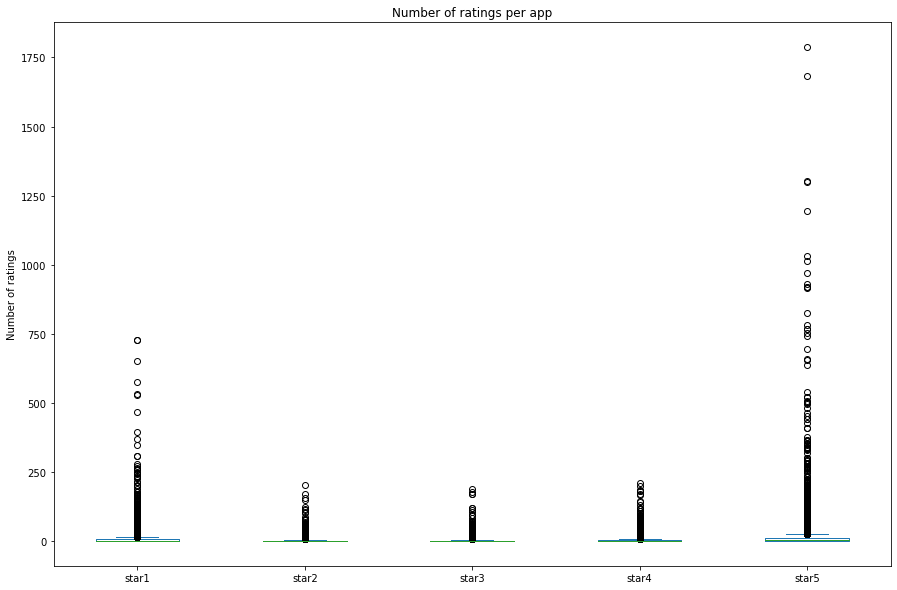

In [26]:
df[["star1", "star2", "star3", "star4", "star5"]].plot.box(title="Number of ratings per app", ylabel="Number of ratings", xlabel="Star rating", figsize=(15, 10))

So it seems like there are far more apps with one stars and five stars then everything else. Not very suprising so far.

So let's look at the raw data and figure out what the mean for each rating is. This should help application authors to see how their app performs relativly to the rest of the ecosystem.

<AxesSubplot:title={'center':'Distribution of ratings over all apps'}, xlabel='Star rating', ylabel='Number of ratings'>

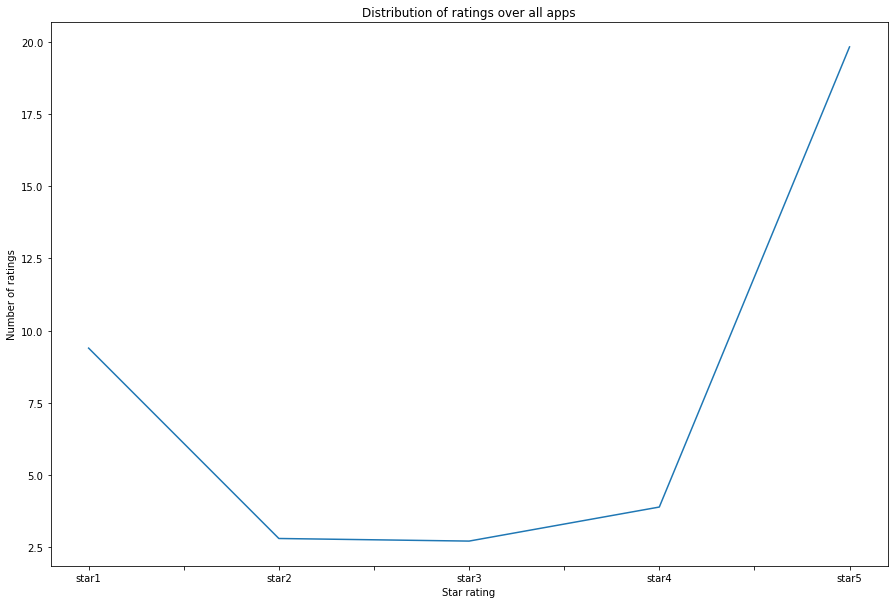

In [27]:
df[["star1", "star2", "star3", "star4", "star5"]].mean().plot(title="Distribution of ratings over all apps", ylabel="Number of ratings", xlabel="Star rating", figsize=(15, 10))

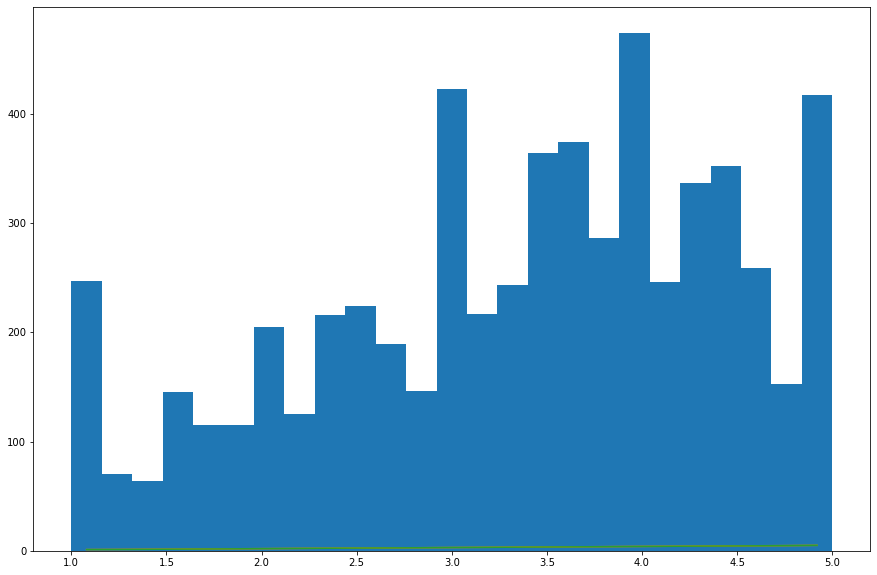

In [63]:
fig, ax = plt.subplots(figsize=(15, 10))

n, bins, patches = ax.hist(x=df["star_average"], bins=25)

group = df.groupby(pd.cut(df.star_average, bins))

plot_centers = (bins [:-1] + bins [1:])/2
plot_values = group.star_average.mean()
plt.plot(plot_centers, plot_values)
plt.plot(plot_centers, group.star_average.quantile(0.25))

#ax.plot(bins, mean, kind="line")
#ax.set_ylabel(r"Rating") 
#ax.set_title(r"Average number of ratings across all apps")

So the average rating of all the apps in the linux ecosystem is around 3.5

Have a look at the top rated apps, unfortunatly there are some duplicates here:

In [ ]:
df.nlargest(20,"confidence")[["star_average", "confidence", "total"]]

,star_average,confidence,total
dash-to-panel_jderose9.github.com,4.850829,4.695125,181
code-url-handler.desktop,4.679261,4.618271,1191
org.speedcrunch.SpeedCrunch,4.962963,4.617511,54
speedcrunch.desktop,4.962963,4.617511,54
io.snapcraft.sublime-text-2kOIsSRmQ7zjpIxzZDpoXaZOVejqaGOT,4.698582,4.611051,564
cool-retro-term.desktop,4.752688,4.595825,186
io.snapcraft.cool-retro-term-6d6yw8CVhAYys3Z09b4sGSwzXSWR6btg,4.752688,4.595825,186
code.desktop,4.634879,4.579010,1531
io.snapcraft.code-Ht0aUHi7ofh9Fbwh6m7jUN2pAy6kzBiu,4.633923,4.577920,1527
com.bitwarden.desktop,4.728070,4.572949,228


So which distros are these reviews coming from?

<AxesSubplot:title={'center':'Distribution of reviews per distribution'}>

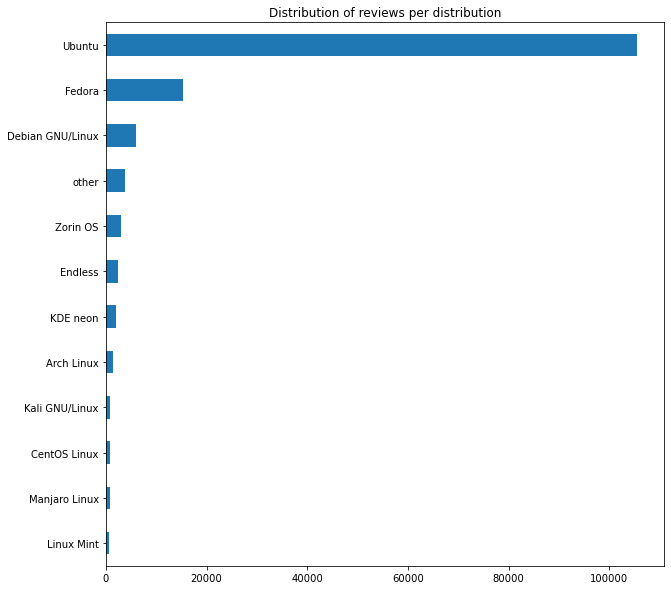

In [ ]:
prob_distro = reviewsDf["distro"].value_counts()

mask = prob_distro > 500
tail_prob_distro = prob_distro.loc[~mask].sum()
prob_distro = prob_distro.loc[mask]
prob_distro['other'] = tail_prob_distro
prob_distro.sort_values().plot(kind='barh', figsize=(10, 10), title="Distribution of reviews per distribution")

Whew, Ubuntu seems to be far ahead.

Which languages are these reviews in?

<AxesSubplot:title={'center':'Distribution of reviews per locale'}>

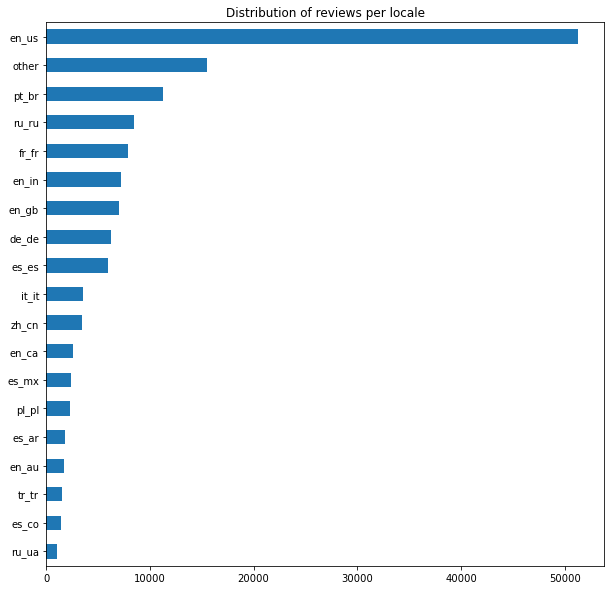

In [ ]:
prob_locale = reviewsDf["locale"].value_counts()

mask = prob_locale > 1000
tail_prob_locale = prob_locale.loc[~mask].sum()
prob_locale = prob_locale.loc[mask]
prob_locale['other'] = tail_prob_locale
prob_locale.sort_values().plot(kind='barh', figsize=(10, 10), title="Distribution of reviews per locale")

Other still showing up so high, might be a good thing. We seem to have reviews in about 200 languages:

In [ ]:
reviewsDf["locale"].unique().size

198

So how many reviews does the system get per day?

<AxesSubplot:title={'center':'Number of reviews per day'}, xlabel='date_created'>

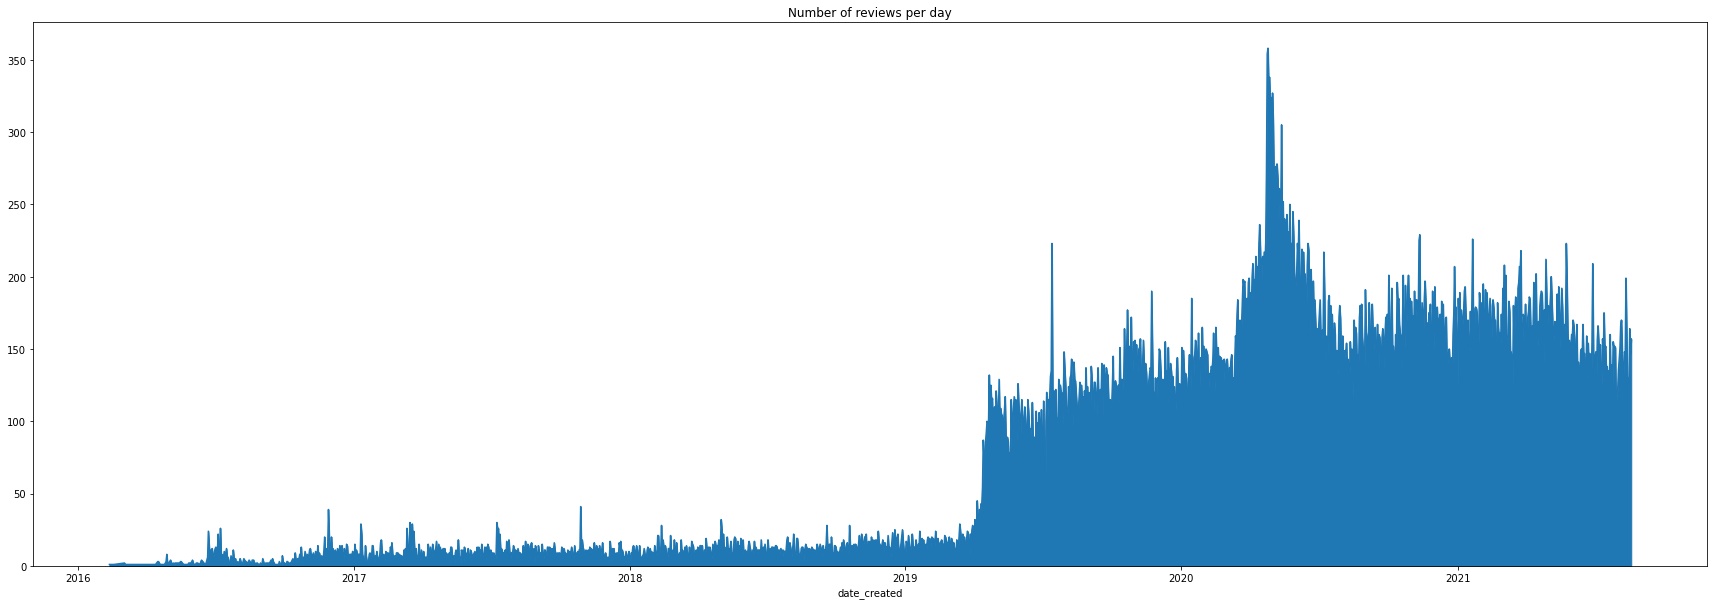

In [ ]:
reviewsDf.groupby(reviewsDf['date_created'].dt.date)["date_created"].count().plot(kind='area', figsize=(30, 10), title="Number of reviews per day")

There are some sharp increases here, let's dig into them.

Let's see how these separate into the top 5 distributions by rating amount:

<AxesSubplot:title={'center':'Number of reviews per day per distribution'}, xlabel='date_created'>

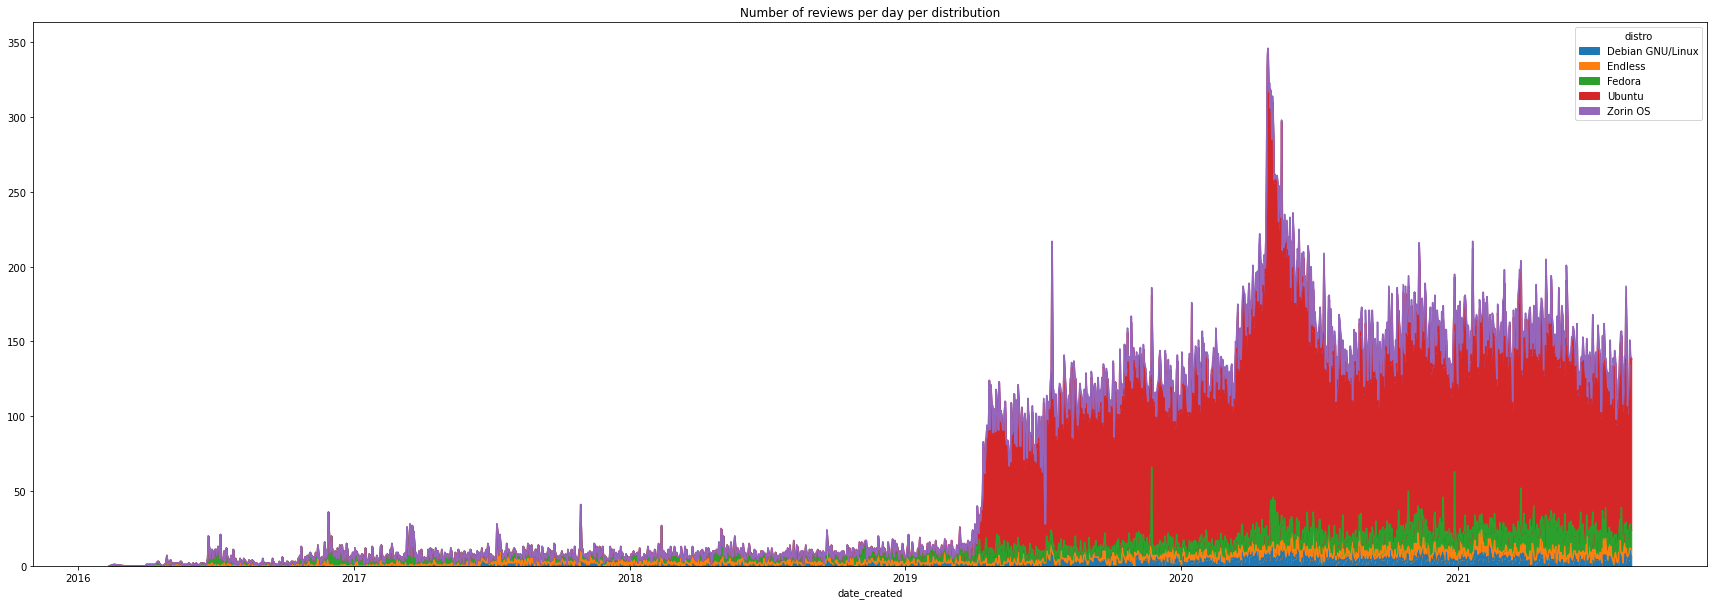

In [ ]:
pivot_table = reviewsDf.groupby([reviewsDf["date_created"].dt.date,"distro"])["date_created"].count().unstack()
pivot_table.loc[:,pivot_table.columns.isin(prob_distro.index.map(lambda x: x).tolist()[:5])].plot(kind='area', figsize=(30, 10), title="Number of reviews per day per distribution")

So in the middle of 2019 it seems like ubuntu people started to send in reviews and basically dwarf every other group. There's also a peak mid 2020, which might be covid related.